***DESARROLLO DE UNA INTELIGENCIA ARTIFICIAL QUE ESTABLEZCA EL GRADO DE SIMILITUD ENTRE MOLÉCULAS***


Autor:

*   Francisco Javier Martínez Moreno



Director:

*   Dr. Antonio Jesús Banegas Luna




##Módulo de importaciones##

In [144]:

'''
Módulo de importaciones

- Este módulo se va ampliando conforme avanza el desarrollo
'''
#Importación de los datasets
import os
import sys
from google.colab import drive

#Carga de datos
from pandas import read_csv #Leer el CSV
import tarfile
from PIL import Image, ImageOps  #Librería de imágenes
import io
import pandas as pd

#Mostrar imágenes
import matplotlib.pyplot as plt

#Para cambiar píxeles imagen
import numpy as np

#Casteo a tensor
from tensorflow.keras.preprocessing.image import img_to_array

#Tensorflow
import tensorflow as tf
from tensorflow.keras import layers, models

#Capas modelo
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv2D, MaxPooling2D, concatenate, GlobalAveragePooling2D, Lambda, Input, BatchNormalization, SeparableConv2D

#Separación de datos
from sklearn import model_selection

#Obtener resultados
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

#Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

#Histogramas de color de las imágenes
import cv2

##Módulo de montaje##

In [145]:
'''
Módulo de montaje para Google Collab con Drive
'''

def montaje_drive():
  drive.mount('/content/gdrive', force_remount=True)
  os.chdir('/content/gdrive/MyDrive/TFG/')


##Módulo de carga de datos##

In [146]:
'''
Módulo de carga de datos
'''


'''
Leer el csv de puntuaciones
'''
def leer_csv(nombre_csv, separador, decimal):
  csv = read_csv(nombre_csv, sep=separador, decimal=decimal)
  return csv


'''
Leer las imágenes
'''
def obtener_imagenes(ruta_imagenes):
  lista_imagenes = []
  imagenes_corruptas = []
  with tarfile.open(ruta_imagenes, 'r:gz') as tar:
      for miembro in tar.getmembers():
          if miembro.isfile():
              contenido_miembro = tar.extractfile(miembro).read()

              try:
                  imagen = Image.open(io.BytesIO(contenido_miembro))
                  lista_imagenes.append((miembro.name, imagen))
              except Exception as e:
                  corrupta = miembro.name.replace('imagenes/', '')
                  corrupta = corrupta.replace('.png', '')
                  imagenes_corruptas.append(corrupta)
                  print(f"La siguiente imagen esta corrupta o no se puede extraer: {miembro.name}")

  columnas = ['Nombre', 'Imagen']
  dataset_imagenes = pd.DataFrame(lista_imagenes, columns=columnas)
  dataset_imagenes['Nombre'] = dataset_imagenes['Nombre'].str.replace('imagenes/', '')
  dataset_imagenes['Nombre'] = dataset_imagenes['Nombre'].str.replace('.png', '')
  return dataset_imagenes, imagenes_corruptas


'''
Quitar las que no se puedan leer
'''
def eliminar_corruptas(asociaciones, imagenes_corruptas):
  eliminar=[]
  for indice, fila in asociaciones.iterrows():
        if fila['query'] in imagenes_corruptas or fila['ligando'] in imagenes_corruptas:
            eliminar.append(indice)
  asociaciones = asociaciones.drop(eliminar)
  return asociaciones


##Módulo de visionado de imágenes##

In [147]:
'''
Módulo de visionado de imágenes
'''

'''
La siguiente función se encarga de mostrar una imagen PIL de forma gráfica
'''
def mostrar_imagen(dataset_imagenes, indice_imagen):
  nombre_imagen = dataset_imagenes.loc[indice_imagen, 'Nombre']
  imagen = dataset_imagenes.loc[indice_imagen, 'Imagen']

  plt.imshow(imagen)
  plt.title(f"Nombre: {nombre_imagen}")
  # Con esta opción no se muestran los recuadros
  plt.axis('off')
  plt.figure(figsize=(15, 10))
  plt.show()

'''
Mostrar un conjunto de imágenes
'''
def mostrar_imagenes(lista_imagenes):
    num_columnas = 4
    num_imagenes = 16
    # // es división entera
    num_filas = (num_imagenes + num_columnas - 1) // num_columnas
    plt.figure(figsize=(15, 10))

    for i in range(num_imagenes):
        imagen = lista_imagenes[i]
        plt.subplot(num_filas, num_columnas, i + 1)
        plt.imshow(imagen)
        plt.axis('off')
    plt.show()

'''
La siguiente función se encarga de mostrar una imagen en numpy array de forma gráfica
'''
def mostrar_numpy_array(imagen):
  plt.imshow(imagen, cmap='gray')
  plt.axis('off')
  plt.show()



'''
Hace un gráfico de los diferentes formatos de píxeles y devuelve cuántos hay de cada tipo
'''

def mostrar_cantidad_pixeles(dataset_imagenes):
  anchos = []
  altos = []

  for imagen in dataset_imagenes['Imagen']:
      ancho, alto = imagen.size
      anchos.append(ancho)
      altos.append(alto)

  # Ancho
  plt.figure(figsize=(10, 6))
  plt.hist(anchos, bins=20, color='skyblue')
  plt.xlabel('Ancho de la imagen')
  plt.ylabel('Frecuencia')
  plt.title('Histograma del ancho de las imágenes')
  plt.show()

  # Alto
  plt.figure(figsize=(10, 6))
  plt.hist(altos, bins=20, color='skyblue')
  plt.xlabel('Alto de la imagen')
  plt.ylabel('Frecuencia')
  plt.title('Histograma del alto de las imágenes')
  plt.show()

  # Se hace un diccionario con los posibles valores y su frecuencia
  # Ancho
  valores_unicos, recuentos = np.unique(anchos, return_counts=True)
  diccionario_recuentos_anchos= dict(zip(valores_unicos, recuentos))
  # Alto
  valores_unicos, recuentos = np.unique(altos, return_counts=True)
  diccionario_recuentos_altos = dict(zip(valores_unicos, recuentos))
  return diccionario_recuentos_anchos, diccionario_recuentos_altos

'''
Te dice qué formato de color tienen las imágenes
'''
def mostrar_formato_color(dataset_imagenes):
  formato_color = []
  for imagen in dataset_imagenes['Imagen']:
      formato = imagen.mode
      formato_color.append(formato)

  valores_unicos, recuentos = np.unique(formato_color, return_counts=True)
  diccionario_formatos= dict(zip(valores_unicos, recuentos))
  return diccionario_formatos

'''
Crea el gráfico para los tres colores
'''

def crear_histograma_color(img):
  #Cambio la imagen de PIL a numpy array para que la entienda cv2
  imagen_numpy = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
  color = ('b','g','r')
  try:
    imagen_rgb = cv2.cvtColor(imagen_numpy, cv2.COLOR_BGR2RGB)
  except Exception as e:
        print("Error al procesar la imagen:", e)

  for i,col in enumerate(color):
      histr = cv2.calcHist([imagen_rgb],[i],None,[256],[0,256])
      plt.plot(histr,color = col)
      plt.xlim([0,256])

  plt.show()

'''
Crea un gráfico para cada color
'''

def crear_histograma_color_numpy(imagen):
  imagen_array = np.array(imagen)

  # Extraer los tres canales de color
  rojo = imagen_array[:,:,0]
  verde = imagen_array[:,:,1]
  azul = imagen_array[:,:,2]

  # Crear histogramas de color
  hist_rojo, bins_rojo = np.histogram(rojo.ravel(), bins=256, range=[0,256])
  hist_verde, bins_verde = np.histogram(verde.ravel(), bins=256, range=[0,256])
  hist_azul, bins_azul = np.histogram(azul.ravel(), bins=256, range=[0,256])


  plt.figure(figsize=(10, 5))
  plt.subplot(1, 3, 1)
  plt.plot(hist_rojo, color='red')
  plt.title('Color Rojo')
  plt.xlabel('Intensidad')
  plt.ylabel('Frecuencia')
  #El .ylim se encarga de limitar los valores mostrados en el eje y
  plt.ylim(0, 1000)

  plt.subplot(1, 3, 2)
  plt.plot(hist_verde, color='green')
  plt.title('Color Verde')
  plt.xlabel('Intensidad')
  plt.ylabel('Frecuencia')
  plt.ylim(0, 1000)

  plt.subplot(1, 3, 3)
  plt.plot(hist_azul, color='blue')
  plt.title('Color Azul')
  plt.xlabel('Intensidad')
  plt.ylabel('Frecuencia')
  plt.ylim(0, 1000)

  plt.tight_layout()
  plt.show()

'''
Crea el gráfico con el dibujo de los contornos
'''

def mostrar_contornos_imagen(imagen):

  imagen = np.array(imagen)
  mostrar_numpy_array(imagen)
  imagen_gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

  imagen_contornos = cv2.Canny(imagen_gris, 30, 200)


  contornos, hierarchy = cv2.findContours(imagen_contornos, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

  imagen_pil = Image.fromarray(imagen_contornos)

  cv2.drawContours(imagen, contornos, -1, (0, 255, 0), 3)

  imagen_pil = Image.fromarray(imagen)
  display(imagen_pil)

'''
Hace el recuento de los contornos
'''

def devolver_contornos_imagenes(listado_imagenes):
  min_contornos = 1000
  max_contornos = 0
  total_contornos = 0
  for i in range(len(listado_imagenes)):
    imagen = listado_imagenes[i]
    imagen = np.array(imagen)
    gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    edged = cv2.Canny(gray, 30, 200)
    contornos, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    numero_contornos = len(contornos)
    if(numero_contornos > max_contornos):
      max_contornos = numero_contornos
    if(numero_contornos < min_contornos):
      min_contornos = numero_contornos
    total_contornos += numero_contornos


  media_contornos = total_contornos / len(listado_imagenes)

  print("Mínimo: {}".format(min_contornos))
  print("Máximo: {}".format(max_contornos))
  print("Media: {:.2f}".format(media_contornos))
  print("Total: {}".format(total_contornos))

'''
Contiene los tres gráficos de comparativas de color
'''

def mostrar_grafico_dispersion_color(imagen):
  imagen = np.array(imagen)
  mostrar_numpy_array(imagen)

  imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)

  # Obtener las dimensiones de la imagen
  alto, ancho, _ = imagen_rgb.shape

  puntos = imagen_rgb.reshape(alto * ancho, 3)


  plt.figure(figsize=(18, 6))

  plt.subplot(1, 3, 1)
  plt.scatter(puntos[:, 0], puntos[:, 1], c=puntos / 255.0, s=1)
  plt.title('Comparación Rojo/Verde')
  plt.xlabel('Canal Rojo')
  plt.ylabel('Canal Verde')

  plt.subplot(1, 3, 2)
  plt.scatter(puntos[:, 1], puntos[:, 2], c=puntos / 255.0, s=1)
  plt.title('Comparación Verde/Azul')
  plt.xlabel('Canal Verde')
  plt.ylabel('Canal Azul')

  plt.subplot(1, 3, 3)
  plt.scatter(puntos[:, 0], puntos[:, 2], c=puntos / 255.0, s=1)
  plt.title('Comparación Rojo/Azul')
  plt.xlabel('Canal Rojo')
  plt.ylabel('Canal Azul')
  plt.show()


'''
Calcular píxeles que no cambian
'''

def calcular_porcentaje_pixeles_iguales(listado_imagenes):
  mismos_valores_totales = 0
  for i in range(len(listado_imagenes)):
    imagen = np.array(listado_imagenes[i])

    imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)

    alto, ancho, _ = imagen.shape

    # Contador para píxeles con los mismos valores en los tres canales
    mismos_valores = 0

    for y in range(alto):
        for x in range(ancho):
            # Obtener los valores de los canales RGB del píxel actual
            canal_r, canal_g, canal_b = imagen[y, x]

            # Comprobar si los tres canales tienen los mismos valores
            if canal_r == canal_g == canal_b:
                mismos_valores += 1

    mismos_valores_totales += mismos_valores

  porcentaje_total = (mismos_valores_totales / (alto * ancho * len(listado_imagenes))) * 100
  print(f"Mismos valores: {mismos_valores_totales}")
  print(f"Porcentaje de píxeles con los mismos valores en los tres canales: {porcentaje_total:.6f}%")


'''
Hace el gráfico de los píxeles
'''

def grafico_digitos(imagen, tamano):
  dem = tamano
  font_size = 12

  tamaño_despues_preprocesado = (tamano, tamano)
  imagen = imagen.resize(tamaño_despues_preprocesado, Image.LANCZOS)

  digit = np.array(imagen)

  max_ax = font_size * dem

  fig, axes = plt.subplots(3, 1, figsize=(24, 24))

  for channel, ax in enumerate(axes):
      ax.set_xlim([0, max_ax])
      ax.set_ylim([0, max_ax])
      ax.axis('off')
      black = '#000000'

      for idx in range(dem):
          for jdx in range(dem):
              pixel_value = int(digit[jdx * (digit.shape[0] // dem), idx * (digit.shape[1] // dem), channel])

              x_position = idx * font_size / 2
              y_position = max_ax - jdx * font_size - 0.5

              t = ax.text(x_position, y_position, str(pixel_value), fontsize=font_size, color=black)
              c = pixel_value / 255.
              t.set_bbox(dict(facecolor=(c, c, c), alpha=0.5, edgecolor='black'))

  plt.tight_layout()
  plt.show()

'''
Info recortes
'''
def obtener_info_recortes(dataset_imagenes):
  info = []
  for i in range(len(dataset_imagenes['Imagen'])):
    imagen = np.array(dataset_imagenes['Imagen'][i])

    gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

    # Aplicar el detector de bordes Canny
    bordes = cv2.Canny(gray, 30, 200)

    # Encontrar contornos en la imagen con bordes
    contours, _ = cv2.findContours(bordes, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Inicializar los límites extremos
    topmost = (0, 0)
    bottommost = (0, 0)
    leftmost = (0, 0)
    rightmost = (0, 0)

    for contour in contours:
        # Obtener los puntos extremos del contorno
        topmost_contour = tuple(contour[contour[:, :, 1].argmin()][0])
        bottommost_contour = tuple(contour[contour[:, :, 1].argmax()][0])
        leftmost_contour = tuple(contour[contour[:, :, 0].argmin()][0])
        rightmost_contour = tuple(contour[contour[:, :, 0].argmax()][0])

        # Actualizar los límites extremos
        if topmost_contour[1] < topmost[1]:
            topmost = topmost_contour
        if bottommost_contour[1] > bottommost[1]:
            bottommost = bottommost_contour
        if leftmost_contour[0] < leftmost[0]:
            leftmost = leftmost_contour
        if rightmost_contour[0] > rightmost[0]:
            rightmost = rightmost_contour

    # Calcular el cuadro delimitador que rodea los contornos extremos con padding de 2 píxeles
    x = max(0, leftmost[0] - 2)
    y = max(0, topmost[1] - 2)
    w = rightmost[0] - leftmost[0] + 4
    h = bottommost[1] - topmost[1] + 4

    info_recorte = {
        'imagen': i,
        'recorte_horizontal': x+w,
        'recorte_vertical': y+h
    }
    info.append(info_recorte)
    return info


'''
Calcular recortes
'''

def calcular_recortes(info):
  recortes_horizontales = [infor['recorte_horizontal'] for infor in info]
  recortes_verticales = [infor['recorte_vertical'] for infor in info]

  total_recorte_horizontal = sum(recortes_horizontales)
  total_recorte_vertical = sum(recortes_verticales)
  media_recorte_horizontal = np.mean(recortes_horizontales)
  media_recorte_vertical = np.mean(recortes_verticales)
  max_recorte_horizontal = max(recortes_horizontales)
  max_recorte_vertical = max(recortes_verticales)
  min_recorte_horizontal = min(recortes_horizontales)
  min_recorte_vertical = min(recortes_verticales)

  # Mostrar los resultados
  print("Total de recorte horizontal:", total_recorte_horizontal)
  print("Total de recorte vertical:", total_recorte_vertical)
  print("Media de recorte horizontal:", media_recorte_horizontal)
  print("Media de recorte vertical:", media_recorte_vertical)
  print("Máximo recorte horizontal:", max_recorte_horizontal)
  print("Máximo recorte vertical:", max_recorte_vertical)
  print("Mínimo recorte horizontal:", min_recorte_horizontal)
  print("Mínimo recorte vertical:", min_recorte_vertical)

  imagen_minimo_horizontal = max(info, key=lambda x: x['recorte_horizontal'])['imagen']

  # Obtener la imagen con el corte vertical mínimo
  imagen_minimo_vertical = max(info, key=lambda x: x['recorte_vertical'])['imagen']

  # Imprimir las imágenes con el corte mínimo
  print("Imagen con corte horizontal mínimo:", imagen_minimo_horizontal)
  print("Imagen con corte vertical mínimo:", imagen_minimo_vertical)

##Módulo de visionado de datos##

In [148]:
'''
Puntuaciones únicas
'''
def mostrar_valores_puntuacion(asociaciones):
  return sorted(asociaciones['score'].unique())

'''
Valores diferentes de puntuación
'''

def mostrar_cantidad_valores_puntuacion(asociaciones):
  return asociaciones['score'].value_counts()

'''
Identificadores únicos
'''

def mostrar_diferentes_identificadores_imagen(asociaciones):
  columnas_identificadores1 = asociaciones['query']
  columnas_identificadores2 = asociaciones['ligando']
  columnas_identificadores1.add(columnas_identificadores2, fill_value=0)
  return columnas_identificadores1

'''
Cantidad de identificadores
'''

def mostrar_cantidad_identificadores(asociaciones):
  columnas_identificadores = pd.concat([asociaciones['query'], asociaciones['ligando']])
  repeticiones_concatenada = columnas_identificadores.value_counts()
  return repeticiones_concatenada
'''
Diagrama de puntos de puntuacion
'''
def crear_diagrama_puntos_puntuacion(distribucion_valores):
  plt.figure(figsize=(20, 6))
  plt.xlabel('Valores Posibles')
  plt.ylabel('Frecuencia')
  plt.title('Distribución de los posibles valores')
  plt.plot(distribucion_valores, 'o')

  plt.show()

'''
Análisis de recortes
'''
def analisis_recortes(dataset_imagenes):
  info_recortes = []

  for i in range(len(dataset_imagenes['Imagen'])):
      # Ruta completa de la imagen
      imagen = dataset_imagenes['Imagen'][i]

      # Cargar la imagen
      imagen = np.array(imagen)

      # Convertir la imagen a escala de grises
      gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

      # Detectar bordes en la imagen utilizando el algoritmo de Canny
      bordes = cv2.Canny(gris, 30, 200)

      # Encontrar los contornos en la imagen de bordes
      contornos, _ = cv2.findContours(bordes, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

      # Calcular el contorno que encierra todos los objetos
      for contorno in contornos:
          # Obtener el cuadro delimitador del contorno
          x, y, w, h = cv2.boundingRect(contorno)

          # Reducir el tamaño del cuadro delimitador para que tenga como máximo 2 píxeles de margen
          margen = 2
          x += margen
          y += margen
          w -= 2 * margen
          h -= 2 * margen

          # Asegurarse de que no se salga de los límites de la imagen
          x = max(0, x)
          y = max(0, y)
          w = min(imagen.shape[1] - x, w)
          h = min(imagen.shape[0] - y, h)

          # Calcular la cantidad de recorte en píxeles
          recorte_horizontal = imagen.shape[1] - w
          recorte_vertical = imagen.shape[0] - h

          # Almacenar la información sobre el recorte de la imagen
          info_recorte = {
              'imagen': i,
              'recorte_horizontal': recorte_horizontal,
              'recorte_vertical': recorte_vertical
          }
          info_recortes.append(info_recorte)

  # Extraer los recortes horizontales y verticales en listas separadas
  recortes_horizontales = [info['recorte_horizontal'] for info in info_recortes]
  recortes_verticales = [info['recorte_vertical'] for info in info_recortes]

  # Calcular el total, la media, el máximo y el mínimo de los recortes horizontales y verticales
  total_recorte_horizontal = sum(recortes_horizontales)
  total_recorte_vertical = sum(recortes_verticales)
  media_recorte_horizontal = np.mean(recortes_horizontales)
  media_recorte_vertical = np.mean(recortes_verticales)
  max_recorte_horizontal = max(recortes_horizontales)
  max_recorte_vertical = max(recortes_verticales)
  min_recorte_horizontal = min(recortes_horizontales)
  min_recorte_vertical = min(recortes_verticales)

  # Mostrar los resultados
  print("Total de recorte horizontal:", total_recorte_horizontal)
  print("Total de recorte vertical:", total_recorte_vertical)
  print("Media de recorte horizontal:", media_recorte_horizontal)
  print("Media de recorte vertical:", media_recorte_vertical)
  print("Máximo recorte horizontal:", max_recorte_horizontal)
  print("Máximo recorte vertical:", max_recorte_vertical)
  print("Mínimo recorte horizontal:", min_recorte_horizontal)
  print("Mínimo recorte vertical:", min_recorte_vertical)


##Módulo de preprocesamiento##

###Tamaño imágenes###

In [149]:
'''
Reduzco los píxeles de la imagen para facilitar el trabajo del modelo
'''

def formatear_tamano_imagenes(imagenes, nuevo_ancho, nuevo_alto):
  for i in range(len(imagenes)):
    tamaño_despues_preprocesado = (nuevo_ancho, nuevo_alto)
    imagenes[i] = imagenes[i].resize(tamaño_despues_preprocesado, Image.LANCZOS)
  return imagenes



###Conversión a escala de grises###

In [150]:
def conversion_escala_grises(dataset_imagenes):
  for i in range(len(dataset_imagenes['Imagen'])):
    dataset_imagenes['Imagen'][i] = ImageOps.grayscale(dataset_imagenes['Imagen'][i])

  canales = dataset_imagenes['Imagen'][0].split()
  return canales


###Tomar imágenes demostración###


In [151]:
def tomar_imagenes_demostracion(dataset_imagenes, asociaciones):
  i=4321
  while True:
    np.random.seed(i)
    i = i + 1
    elegida = dataset_imagenes['Nombre'].sample(1).iloc[0]

    filas_filtradas = asociaciones[asociaciones['query'] == elegida]
    if len(filas_filtradas) > 5:
      filas_aleatorias = filas_filtradas.sample(5)
      asociaciones = asociaciones.drop(filas_aleatorias.index)
      dataset_demostracion = crear_asociaciones(filas_aleatorias, dataset_imagenes)
      return asociaciones, dataset_demostracion


###Asociación de imágenes###

In [152]:
'''
Este módulo busca tomar los datasets "dataset_imagenes" y "asociaciones" y crear un nuevo dataset con las dos imágenes ya preprocesadas y su puntuación final
'''

def crear_asociaciones(asociaciones, dataset_imagenes):
  datos_entrenar=[]
  for fila in asociaciones.itertuples(index=False):
    #Tomo los tres valores de cada fila de asociaciones
    primer_id = fila.query
    segundo_id = fila.ligando
    puntuacion = fila.score
    #Busco los ids en el dataset_imagenes
    try:
      primera_imagen = dataset_imagenes[dataset_imagenes['Nombre'] == primer_id].values[0]
    except Exception as e:
      print(f"La imagen {primer_id} no se ha encontrado")

    try:
      segunda_imagen = dataset_imagenes[dataset_imagenes['Nombre'] == segundo_id].values[0]
    except Exception as e:
      print(f"La imagen {segundo_id} no se ha encontrado")

    if primera_imagen is not None and segunda_imagen is not None:
      datos_entrenar.append((primera_imagen[1], segunda_imagen[1], puntuacion))

  dataset_entrenar = pd.DataFrame(datos_entrenar, columns=['primera_imagen', 'segunda_imagen', 'puntuacion'])
  return dataset_entrenar


###Casteo a tensor###

In [153]:
def pasar_a_array(imagen):
    imagen_array = img_to_array(imagen)
    return imagen_array

def castear_a_tensor(dataset_entrenar):
  dataset_entrenar['primera_imagen'] = dataset_entrenar['primera_imagen'].apply(pasar_a_array)
  dataset_entrenar['segunda_imagen'] = dataset_entrenar['segunda_imagen'].apply(pasar_a_array)
  return dataset_entrenar





###Normalización###

In [154]:
def normalizacion(dataset_entrenar):
  for i in range(len(dataset_entrenar['primera_imagen'])):
    dataset_entrenar['primera_imagen'][i] = dataset_entrenar['primera_imagen'][i] / 255
    dataset_entrenar['segunda_imagen'][i] = dataset_entrenar['segunda_imagen'][i] / 255
  return dataset_entrenar


###Intercambio blanco por negro###

In [155]:
def intercambio_blanco_negro(dataset_entrenar):
  for i in range(len(dataset_entrenar['primera_imagen'])):
    dataset_entrenar['primera_imagen'][i] = 1 - dataset_entrenar['primera_imagen'][i]
    dataset_entrenar['segunda_imagen'][i] = 1 - dataset_entrenar['segunda_imagen'][i]
  return dataset_entrenar

###Eliminar dimensión canal###

In [156]:
def eliminar_dimension_canal(dataset_entrenar):
  for i in range(len(dataset_entrenar['primera_imagen'])):
    dataset_entrenar['primera_imagen'][i] = dataset_entrenar['primera_imagen'][i][:, :, 0]
    dataset_entrenar['segunda_imagen'][i] = dataset_entrenar['segunda_imagen'][i][:, :, 0]
  return dataset_entrenar

###Recortar datos###

In [157]:
def eliminar_filas(dataset_entrenar):
  filas = int(len(dataset_entrenar)/2)
  dataset_entrenar = dataset_entrenar.drop(dataset_entrenar.index[:filas])
  return dataset_entrenar

###Eliminar ceros###

In [158]:
def eliminar_ceros(dataset_entrenar):
  dataset_entrenar = dataset_entrenar[dataset_entrenar['puntuacion'] != 0]
  return dataset_entrenar

##Módulo separación datos##

In [159]:

def separar_datos(dataset_entrenar, tamano_validacion, tamano_test, semilla):
  caracteristicas1 = np.stack(dataset_entrenar['primera_imagen'].to_numpy())
  caracteristicas2 = np.stack(dataset_entrenar['segunda_imagen'].to_numpy())
  objetivo = dataset_entrenar['puntuacion'].astype('float32')

  #caracteristicas1_train, caracteristicas1_val, caracteristicas2_train, caracteristicas2_val, etiquetas_train, etiquetas_val = model_selection.train_test_split(
  #    caracteristicas1, caracteristicas2, objetivo, test_size=tamano_test, random_state=semilla)

  caracteristicas1_train, caracteristicas1_temp, caracteristicas2_train, caracteristicas2_temp, etiquetas_train, etiquetas_temp = model_selection.train_test_split(
      caracteristicas1, caracteristicas2, objetivo, test_size=tamano_validacion, random_state=semilla)

  caracteristicas1_val, caracteristicas1_test, caracteristicas2_val, caracteristicas2_test, etiquetas_val, etiquetas_test = model_selection.train_test_split(
      caracteristicas1_temp, caracteristicas2_temp, etiquetas_temp, test_size=tamano_test, random_state=semilla)

  return caracteristicas1_train, caracteristicas1_val, caracteristicas1_test, caracteristicas2_train, caracteristicas2_val, caracteristicas2_test, etiquetas_train, etiquetas_val, etiquetas_test



##Módulo creación modelos##

Este modelo sirve como prueba inicial para ver la mejora del rendimiento de los distintos modelos.

###Modelo Básico###

In [160]:
def crear_modelo_basico(nuevo_ancho, nuevo_alto, canales):
  modelo1 = Sequential([
      Conv2D(filters=16, kernel_size=(3,3), input_shape=(nuevo_ancho, nuevo_alto, canales), activation='relu'),
      MaxPooling2D(pool_size=(2,2)),
      Flatten()
  ])

  modelo2 = Sequential([
      Conv2D(filters=16, kernel_size=(3,3), input_shape=(nuevo_ancho, nuevo_alto, canales), activation='relu'),
      MaxPooling2D(pool_size=(2,2)),
      Flatten()
  ])

  concatenacion = concatenate([modelo1.output, modelo2.output])

  capa_output = Dense(1, activation='linear')(concatenacion)


  modeloFinal = Model(inputs=[modelo1.input, modelo2.input], outputs=capa_output)

  return modeloFinal

###Modelo Lambda###

In [161]:
def crear_modelo_medio(nuevo_ancho, nuevo_alto, canales):
  input_layer1 = Input(shape=(nuevo_ancho, nuevo_alto, canales))
  input_layer2 = Input(shape=(nuevo_ancho, nuevo_alto, canales))

  modelo1 = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(input_layer1)
  modelo1 = MaxPooling2D(pool_size=(2,2)) (modelo1)
  modelo1 = Conv2D(64, (3, 3), activation='relu') (modelo1)
  modelo1 = MaxPooling2D(pool_size=(2,2)) (modelo1)
  modelo1 = Conv2D(128, (3, 3), activation='relu') (modelo1)
  modelo1 = GlobalAveragePooling2D() (modelo1)

  modelo2 = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(input_layer2)
  modelo2 = MaxPooling2D(pool_size=(2,2)) (modelo2)
  modelo2 = Conv2D(64, (3, 3), activation='relu') (modelo2)
  modelo2 = MaxPooling2D(pool_size=(2,2)) (modelo2)
  modelo2 = Conv2D(128, (3, 3), activation='relu') (modelo2)
  modelo2 = GlobalAveragePooling2D() (modelo2)

  #concatenacion = concatenate([modelo1.output, modelo2.output])

  resta = Lambda(lambda x: abs(x[0] - x[1]))([modelo1, modelo2])

  capa_densa = Dense(128, activation='relu')(resta)
  capa_output = Dense(1, activation='linear')(capa_densa)


  modeloFinal = Model(inputs=[input_layer1, input_layer2], outputs=capa_output)

  return modeloFinal

###Modelo XCeption###

In [162]:
def entry_flow(inputs) :

    x = Conv2D(32, 3, strides = 2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64,3,padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    previous_block_activation = x

    for size in [128, 256, 728] :

        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D(3, strides=2, padding='same')(x)

        residual = Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)

        x = tf.keras.layers.Add()([x, residual])
        previous_block_activation = x

    return x

def middle_flow(x, num_blocks=8) :

    previous_block_activation = x

    for _ in range(num_blocks) :

        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = tf.keras.layers.Add()([x, previous_block_activation])
        previous_block_activation = x

    return x
def exit_flow(x) :

    previous_block_activation = x

    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D(3, strides=2, padding='same')(x)

    residual = Conv2D(1024, 1, strides=2, padding='same')(previous_block_activation)
    x = tf.keras.layers.Add()([x, residual])

    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = GlobalAveragePooling2D()(x)
    #x = Dense(1, activation='linear')(x)

    return x

def crear_modelo_xception(nuevo_alto, nuevo_ancho, canales):
  primer_input = Input(shape=(nuevo_alto, nuevo_ancho, canales))
  primer_output = exit_flow(middle_flow(entry_flow(primer_input)))

  segundo_input = Input(shape=(nuevo_alto, nuevo_ancho, canales))
  segundo_output = exit_flow(middle_flow(entry_flow(segundo_input)))

  concatenacion = concatenate([primer_output, segundo_output])

  capa_output = Dense(1, activation='linear')(concatenacion)

  modeloFinal = Model(inputs=[primer_input, segundo_input], outputs=capa_output)

  return modeloFinal

##Módulo de compilación##

In [163]:
'''
Compilación del modelo
'''
def compilar_modelo(modelo, optimizador, perdida):
  modelo.compile(optimizer = optimizador,loss = perdida)



##Módulo de entrenamiento##

In [164]:
def entrenar_modelo(modelo, caracteristicas1_train, caracteristicas2_train, etiquetas_train, epocas, batch_size, caracteristicas1_val, caracteristicas2_val, etiquetas_val):
  modelo.fit([caracteristicas1_train, caracteristicas2_train], etiquetas_train , validation_data=(
      [caracteristicas1_val, caracteristicas2_val], etiquetas_val), epochs=epocas, batch_size=batch_size,
             callbacks=[
    EarlyStopping(monitor='val_loss', mode='min', min_delta=0, patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.5, patience=10, min_delta=0, min_lr=0.0001)]
             )



##Módulo de predicción##

In [165]:
def predecir_modelo(modelo, caracteristicas1_test, caracteristicas2_test):
  predicciones = modelo.predict([caracteristicas1_test, caracteristicas2_test])
  return predicciones

##Módulo de resultados##

In [166]:
'''
Cálculo de las métricas de R cuadrado, MSE, RMSE, MAE, MAPE
'''

def obtener_resultados(etiquetas_test, predicciones):
  r2 = r2_score(etiquetas_test, predicciones)
  print(f'R2: {r2}')

  mse = mean_squared_error(etiquetas_test, predicciones)
  print(f'MSE: {mse}')

  mae = mean_absolute_error(etiquetas_test, predicciones)
  print(f'MAE: {mae}')

  rmse = mean_squared_error(etiquetas_test, predicciones, squared=False)
  print(f'RMSE: {rmse}')

  suma_errors = 0
  epsilon = 0.0001  # Un valor muy pequeño
  for true_val, pred_val in zip(etiquetas_test, predicciones):
      true_val = max(true_val, epsilon)
      suma_errors += abs((true_val - pred_val) / true_val)
  mape2 = (suma_errors / len(etiquetas_test)) * 100
  print(f'MAPE: {mape2}%')

##Módulo de ejecución##

###Ejecución carga datos###

In [167]:
def cargar_datos(csv, url_imagenes):
  #Ejecutar módulo de carga de datos, con la opción de csv
  asociaciones = leer_csv(csv, ',', '.')

  #Ejecutar módulo de carga de datos, con la opción de leer de Drive
  dataset_imagenes, imagenes_corruptas = obtener_imagenes(url_imagenes)

  print(imagenes_corruptas)

  #Ejecutar módulo de carga de datos, con la opción de eliminar las imágenes corruptas
  asociaciones = eliminar_corruptas(asociaciones, imagenes_corruptas)
  return asociaciones, dataset_imagenes

###Ejecución preprocesamiento###

In [168]:
def preprocesar(dataset_imagenes, nuevo_ancho, nuevo_alto, opciones, asociaciones):
  '''
  Cambiar tamaño imágenes
  '''
  if opciones[0] == True:
    dataset_imagenes['Imagen'] = formatear_tamano_imagenes(dataset_imagenes['Imagen'], nuevo_ancho, nuevo_alto)

  #Ejemplo del resultado
  print("Tamaño: ")
  print(dataset_imagenes['Imagen'][0].size)


  '''
  Cambiar a escala de grises
  '''
  if opciones[1] == True:
    canales = conversion_escala_grises(dataset_imagenes)
    print("Cambiado a gris")


  '''
  Tomar imágenes demostración

  asociaciones, dataset_demostracion = tomar_imagenes_demostracion(dataset_imagenes, asociaciones)
  print(dataset_demostracion)
  '''

  '''
  Asociar imágenes a su puntuación
  '''
  dataset_entrenar = crear_asociaciones(asociaciones, dataset_imagenes)


  '''
  Castear a tensor
  '''
  dataset_entrenar = castear_a_tensor(dataset_entrenar)
  #dataset_demostracion = castear_a_tensor(dataset_demostracion)

  '''
  Normalización
  '''
  if opciones[2] == True:
    dataset_entrenar = normalizacion(dataset_entrenar)
    #dataset_demostracion = normalizacion(dataset_demostracion)

  '''
  Paso de blanco a negro
  '''
  if opciones[3] == True:
    dataset_entrenar = intercambio_blanco_negro(dataset_entrenar)
    #dataset_demostracion = intercambio_blanco_negro(dataset_demostracion)

  '''
  Eliminar dimensión canal
  '''
  if opciones[4] == True:
    dataset_entrenar = eliminar_dimension_canal(dataset_entrenar)
    #dataset_demostracion = eliminar_dimension_canal(dataset_demostracion)
  '''
  Eliminar filas
  '''
  if opciones[5] == True:
    dataset_entrenar = eliminar_filas(dataset_entrenar)

  '''
   Eliminar ceros
  '''
  if opciones[6] == True:
    dataset_entrenar = eliminar_ceros(dataset_entrenar)
  return dataset_entrenar

###Ejecución de modelos###

####Ejecución modelo básico####

In [169]:
def ejecutar_basico(epocas, batch_size, canales, datos, nuevo_ancho, nuevo_alto):
  print("Modelo básico")
  modeloBasico = crear_modelo_basico(nuevo_ancho, nuevo_alto, canales)
  compilar_modelo(modeloBasico, "adam", "mean_squared_error")
  entrenar_modelo(modeloBasico, datos['caracteristicas1_train'], datos['caracteristicas2_train'], datos['etiquetas_train'], epocas, batch_size, datos['caracteristicas1_val'], datos['caracteristicas2_val'], datos['etiquetas_val'])
  predicciones_basico = predecir_modelo(modeloBasico, datos['caracteristicas1_test'], datos['caracteristicas2_test'])

  print()
  print("Resultados: ")
  obtener_resultados(datos['etiquetas_test'], predicciones_basico)
  modeloBasico.save('/content/gdrive/MyDrive/TFG/pesosBasico.h5')
  return predicciones_basico


####Ejecución modelo lambda####

In [170]:
def ejecutar_lambda(epocas, batch_size, canales, datos, nuevo_ancho, nuevo_alto):

  print("Modelo lambda")
  modeloLambda = crear_modelo_medio(nuevo_ancho, nuevo_alto, canales)
  compilar_modelo(modeloLambda, "adam", "mean_squared_error")
  entrenar_modelo(modeloLambda, datos['caracteristicas1_train'], datos['caracteristicas2_train'], datos['etiquetas_train'], epocas, batch_size, datos['caracteristicas1_val'], datos['caracteristicas2_val'], datos['etiquetas_val'])
  predicciones_lambda = predecir_modelo(modeloLambda, datos['caracteristicas1_test'], datos['caracteristicas2_test'])

  print()
  print("Resultados: ")
  obtener_resultados(datos['etiquetas_test'], predicciones_lambda)
  return predicciones_lambda


####Ejecución modelo XCeption####

In [171]:
def ejecutar_xception(epocas, batch_size, canales, datos, nuevo_ancho, nuevo_alto):

  print("Modelo exception")
  modeloXCeption= crear_modelo_xception(nuevo_ancho, nuevo_alto, canales)
  compilar_modelo(modeloXCeption, "adam", "mean_squared_error")
  entrenar_modelo(modeloXCeption, datos['caracteristicas1_train'], datos['caracteristicas2_train'], datos['etiquetas_train'], epocas, batch_size, datos['caracteristicas1_val'], datos['caracteristicas2_val'], datos['etiquetas_val'])
  predicciones_xception = predecir_modelo(modeloXCeption, datos['caracteristicas1_test'], datos['caracteristicas2_test'])

  print()
  print("Resultados: ")
  obtener_resultados(datos['etiquetas_test'], predicciones_xception)
  return predicciones_xception

#Selección de la ejecución#

##Selección carga y preprocesamiento##

###Montaje###

In [172]:
montaje_drive()

Mounted at /content/gdrive


###Parámetros de inicio###

In [173]:
nuevo_ancho = 32
nuevo_alto = 32
canales = 1
epocas = 10

###Carga###

In [174]:
csv = 'dataset-v1.csv'
url_imagenes = '/content/gdrive/MyDrive/TFG/imagenes.tgz'


opciones = [None] * 7
#Tamano
opciones[0] = True
#Gris
if canales == 1:
  opciones[1] = True
else:
  opciones[1] = False
#Normalizar
opciones[2] = True
#Blanco-negro
opciones[3] = True
#Eliminar canal
opciones[4] = False
#Eliminar filas
opciones[5] = False
#Eliminar ceros
opciones[6] = False

asociaciones, dataset_imagenes = cargar_datos(csv, url_imagenes)



La siguiente imagen esta corrupta o no se puede extraer: imagenes/C00059.png
La siguiente imagen esta corrupta o no se puede extraer: imagenes/C00058.png
La siguiente imagen esta corrupta o no se puede extraer: imagenes/DB09413.png
La siguiente imagen esta corrupta o no se puede extraer: imagenes/C00209.png
La siguiente imagen esta corrupta o no se puede extraer: imagenes/DB09449.png
['C00059', 'C00058', 'DB09413', 'C00209', 'DB09449']


###Visualización datos###

####Nominales####

In [175]:
'''
Mostrar distribución de identificadores
'''
identificadores = mostrar_cantidad_identificadores(asociaciones)
identificadores_diccionario = identificadores.to_dict()
print((identificadores.sort_values(ascending=False).head(10)))



C00001    1
C03338    1
C02804    1
C02812    1
C02817    1
C00189    1
C02827    1
C02837    1
C02846    1
C02938    1
Name: count, dtype: int64


####Numéricos####

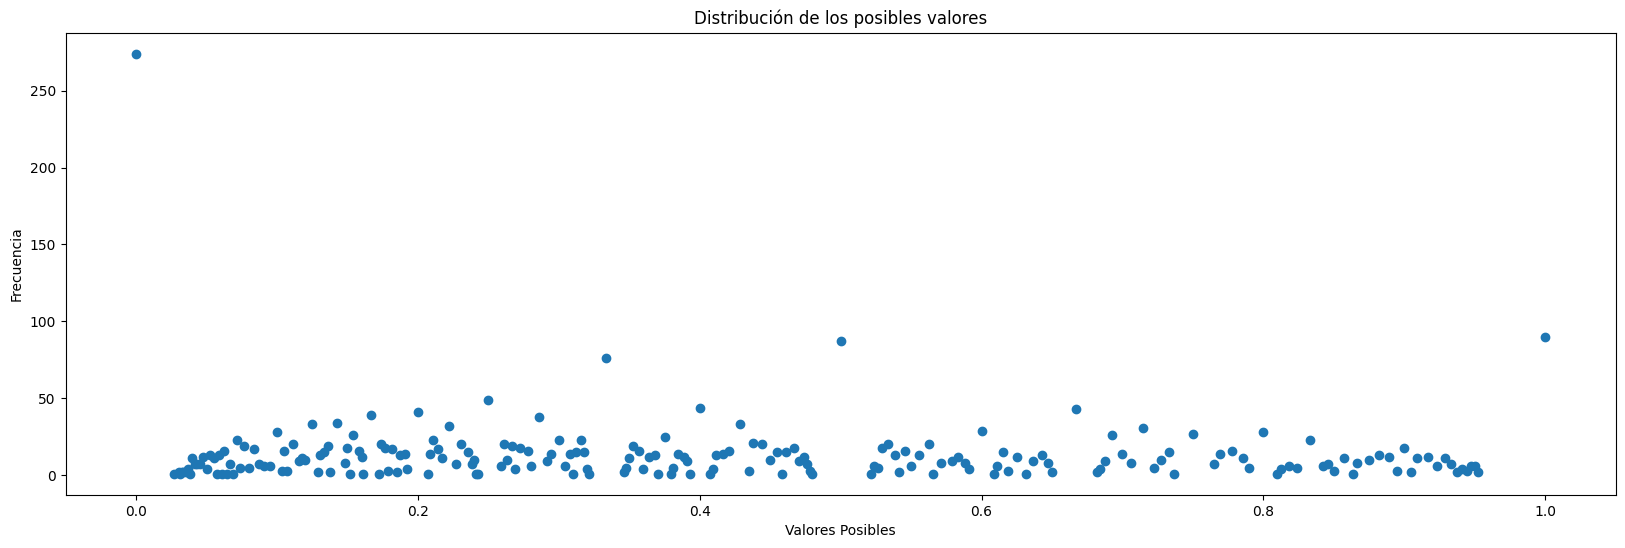

In [176]:
'''
Mostrar diagrama de puntos
'''
valores_posibles = mostrar_valores_puntuacion(asociaciones)
distribucion_valores = mostrar_cantidad_valores_puntuacion(asociaciones)

crear_diagrama_puntos_puntuacion(distribucion_valores)


###Visualización de imágenes###

####Formato####

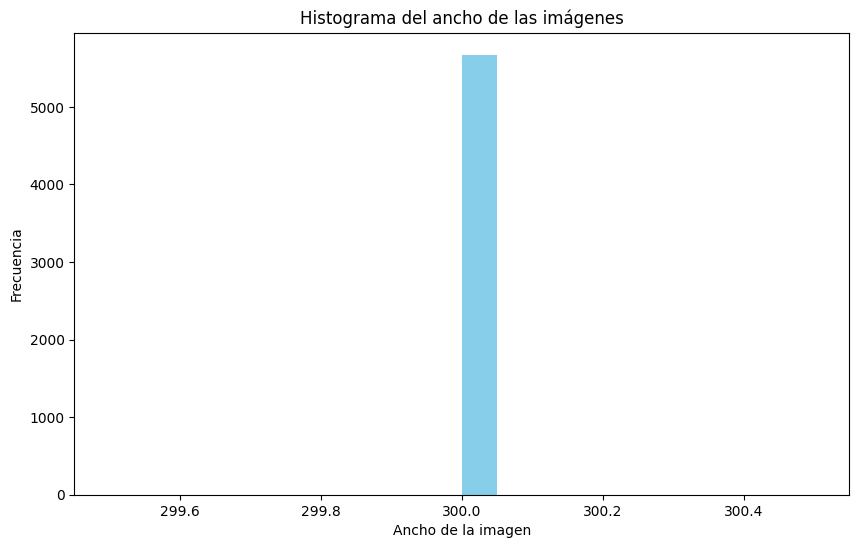

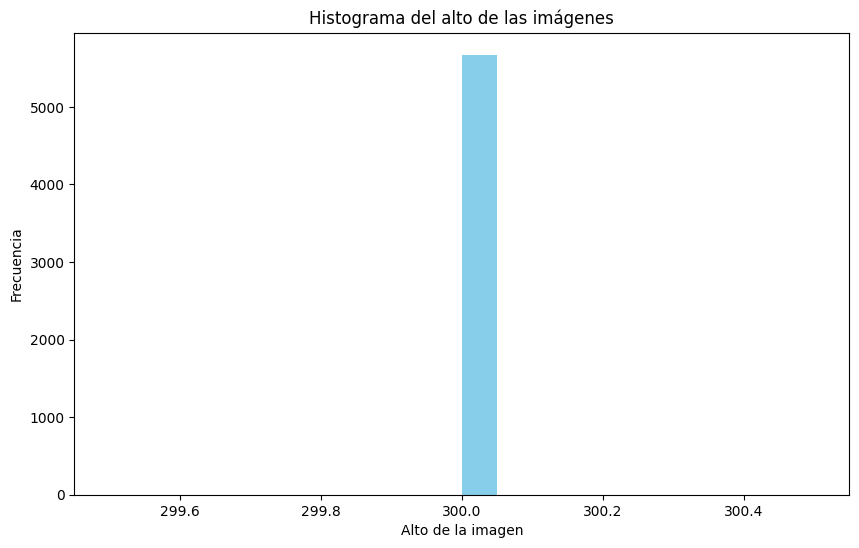

Valores de ancho: 
{300: 5673}
Valores de alto: 
{300: 5673}


In [177]:
'''
Mostrar anchos y altos
'''
anchos_eda, altos_eda = mostrar_cantidad_pixeles(dataset_imagenes)
print("Valores de ancho: ")
print(anchos_eda)
print("Valores de alto: ")
print(altos_eda)

In [178]:
'''
Mostrar tamaños y colores
'''
diccionario_formatos = mostrar_formato_color(dataset_imagenes)

anchos_eda.update(altos_eda)
anchos_eda.update(diccionario_formatos)
print(anchos_eda)

{300: 5673, 'RGB': 5673}


####Contornos####

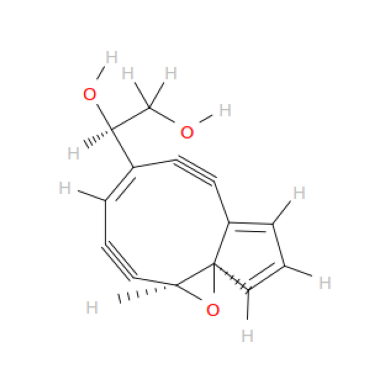

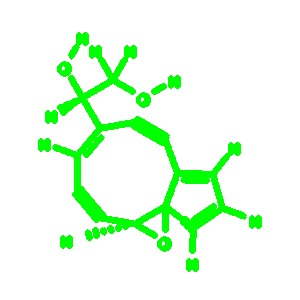

In [179]:
'''
Ver contornos
'''
mostrar_contornos_imagen(dataset_imagenes['Imagen'][3783])

In [180]:
'''
Calcular contornos
'''
devolver_contornos_imagenes(dataset_imagenes['Imagen'])

Mínimo: 0
Máximo: 105
Media: 26.24
Total: 148852


####Recortes####

In [181]:
'''
Análisis de recortes
'''
analisis_recortes(dataset_imagenes)


Total de recorte horizontal: 42991480
Total de recorte vertical: 42844614
Media de recorte horizontal: 288.8203047322172
Media de recorte vertical: 287.8336468438449
Máximo recorte horizontal: 303
Máximo recorte vertical: 303
Mínimo recorte horizontal: 60
Mínimo recorte vertical: 59


In [182]:
'''
Calcular recortes
'''
info = obtener_info_recortes(dataset_imagenes)
calcular_recortes(info)

Total de recorte horizontal: 279
Total de recorte vertical: 230
Media de recorte horizontal: 279.0
Media de recorte vertical: 230.0
Máximo recorte horizontal: 279
Máximo recorte vertical: 230
Mínimo recorte horizontal: 279
Mínimo recorte vertical: 230
Imagen con corte horizontal mínimo: 0
Imagen con corte vertical mínimo: 0


####Color####

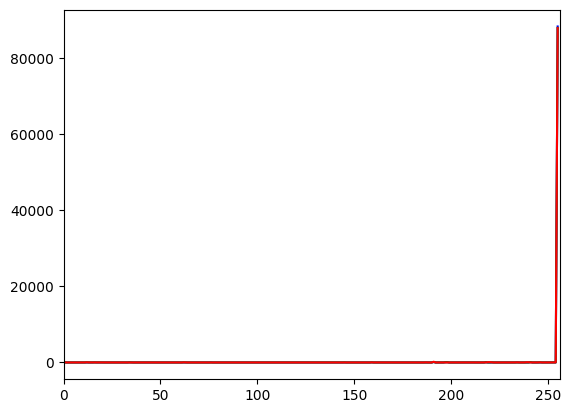

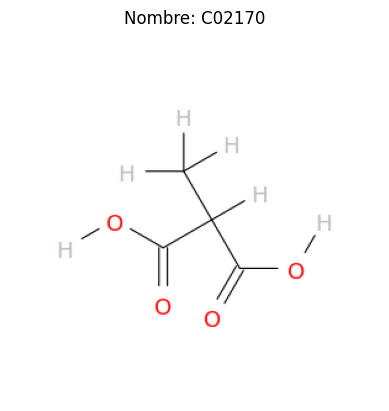

<Figure size 1500x1000 with 0 Axes>

In [183]:
'''
Cálculo del histograma de color
'''
crear_histograma_color(dataset_imagenes['Imagen'][103])

mostrar_imagen(dataset_imagenes, 103)

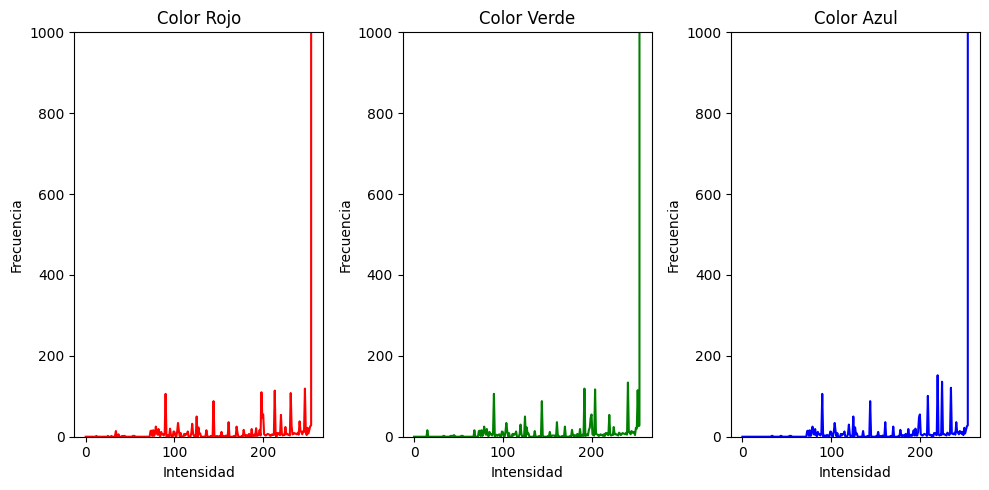

In [184]:
crear_histograma_color_numpy(dataset_imagenes['Imagen'][0])
#Reescalar la imagen para que se vea bien los picos
#Interesante pasar a gris, porque ahí todos los tonos son iguales

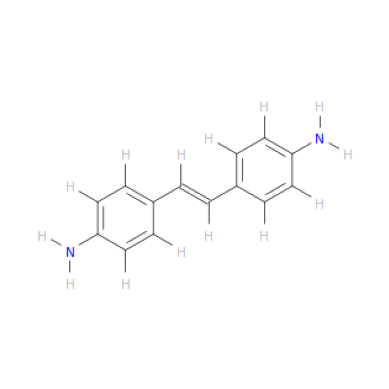

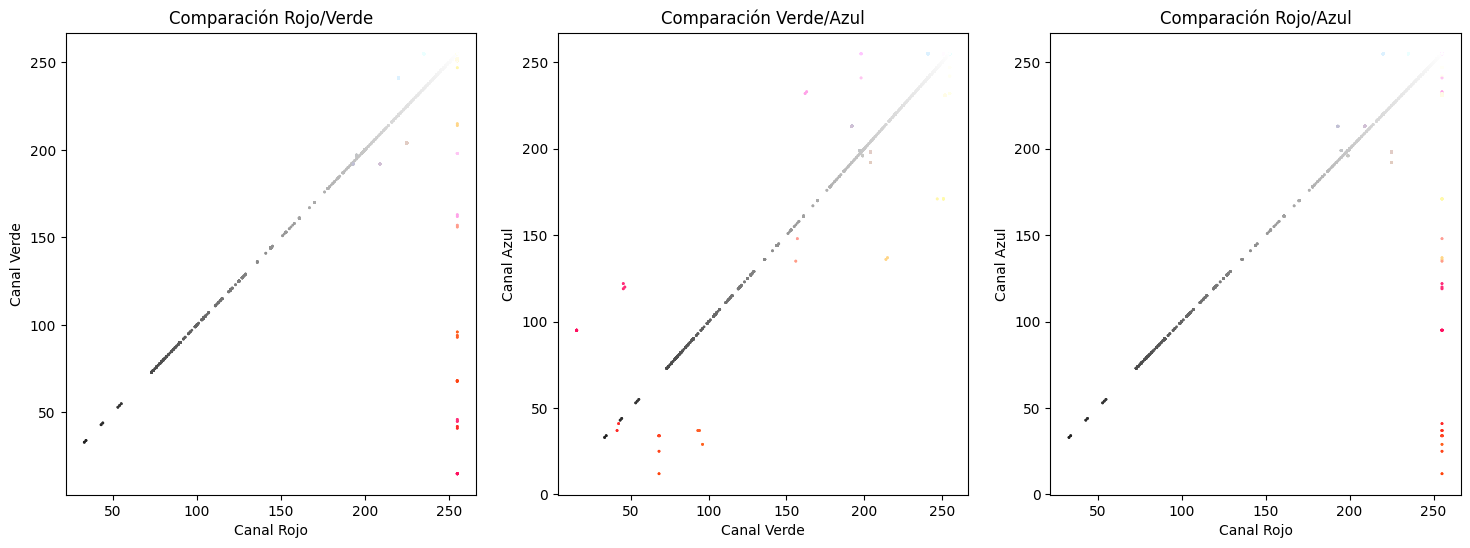

In [185]:
'''
Dispersión de color
'''
mostrar_grafico_dispersion_color(dataset_imagenes['Imagen'][0])

In [186]:
'''
Porcentaje de pixeles iguales
'''
calcular_porcentaje_pixeles_iguales(dataset_imagenes['Imagen'])

Mismos valores: 504924810
Porcentaje de píxeles con los mismos valores en los tres canales: 98.894336%


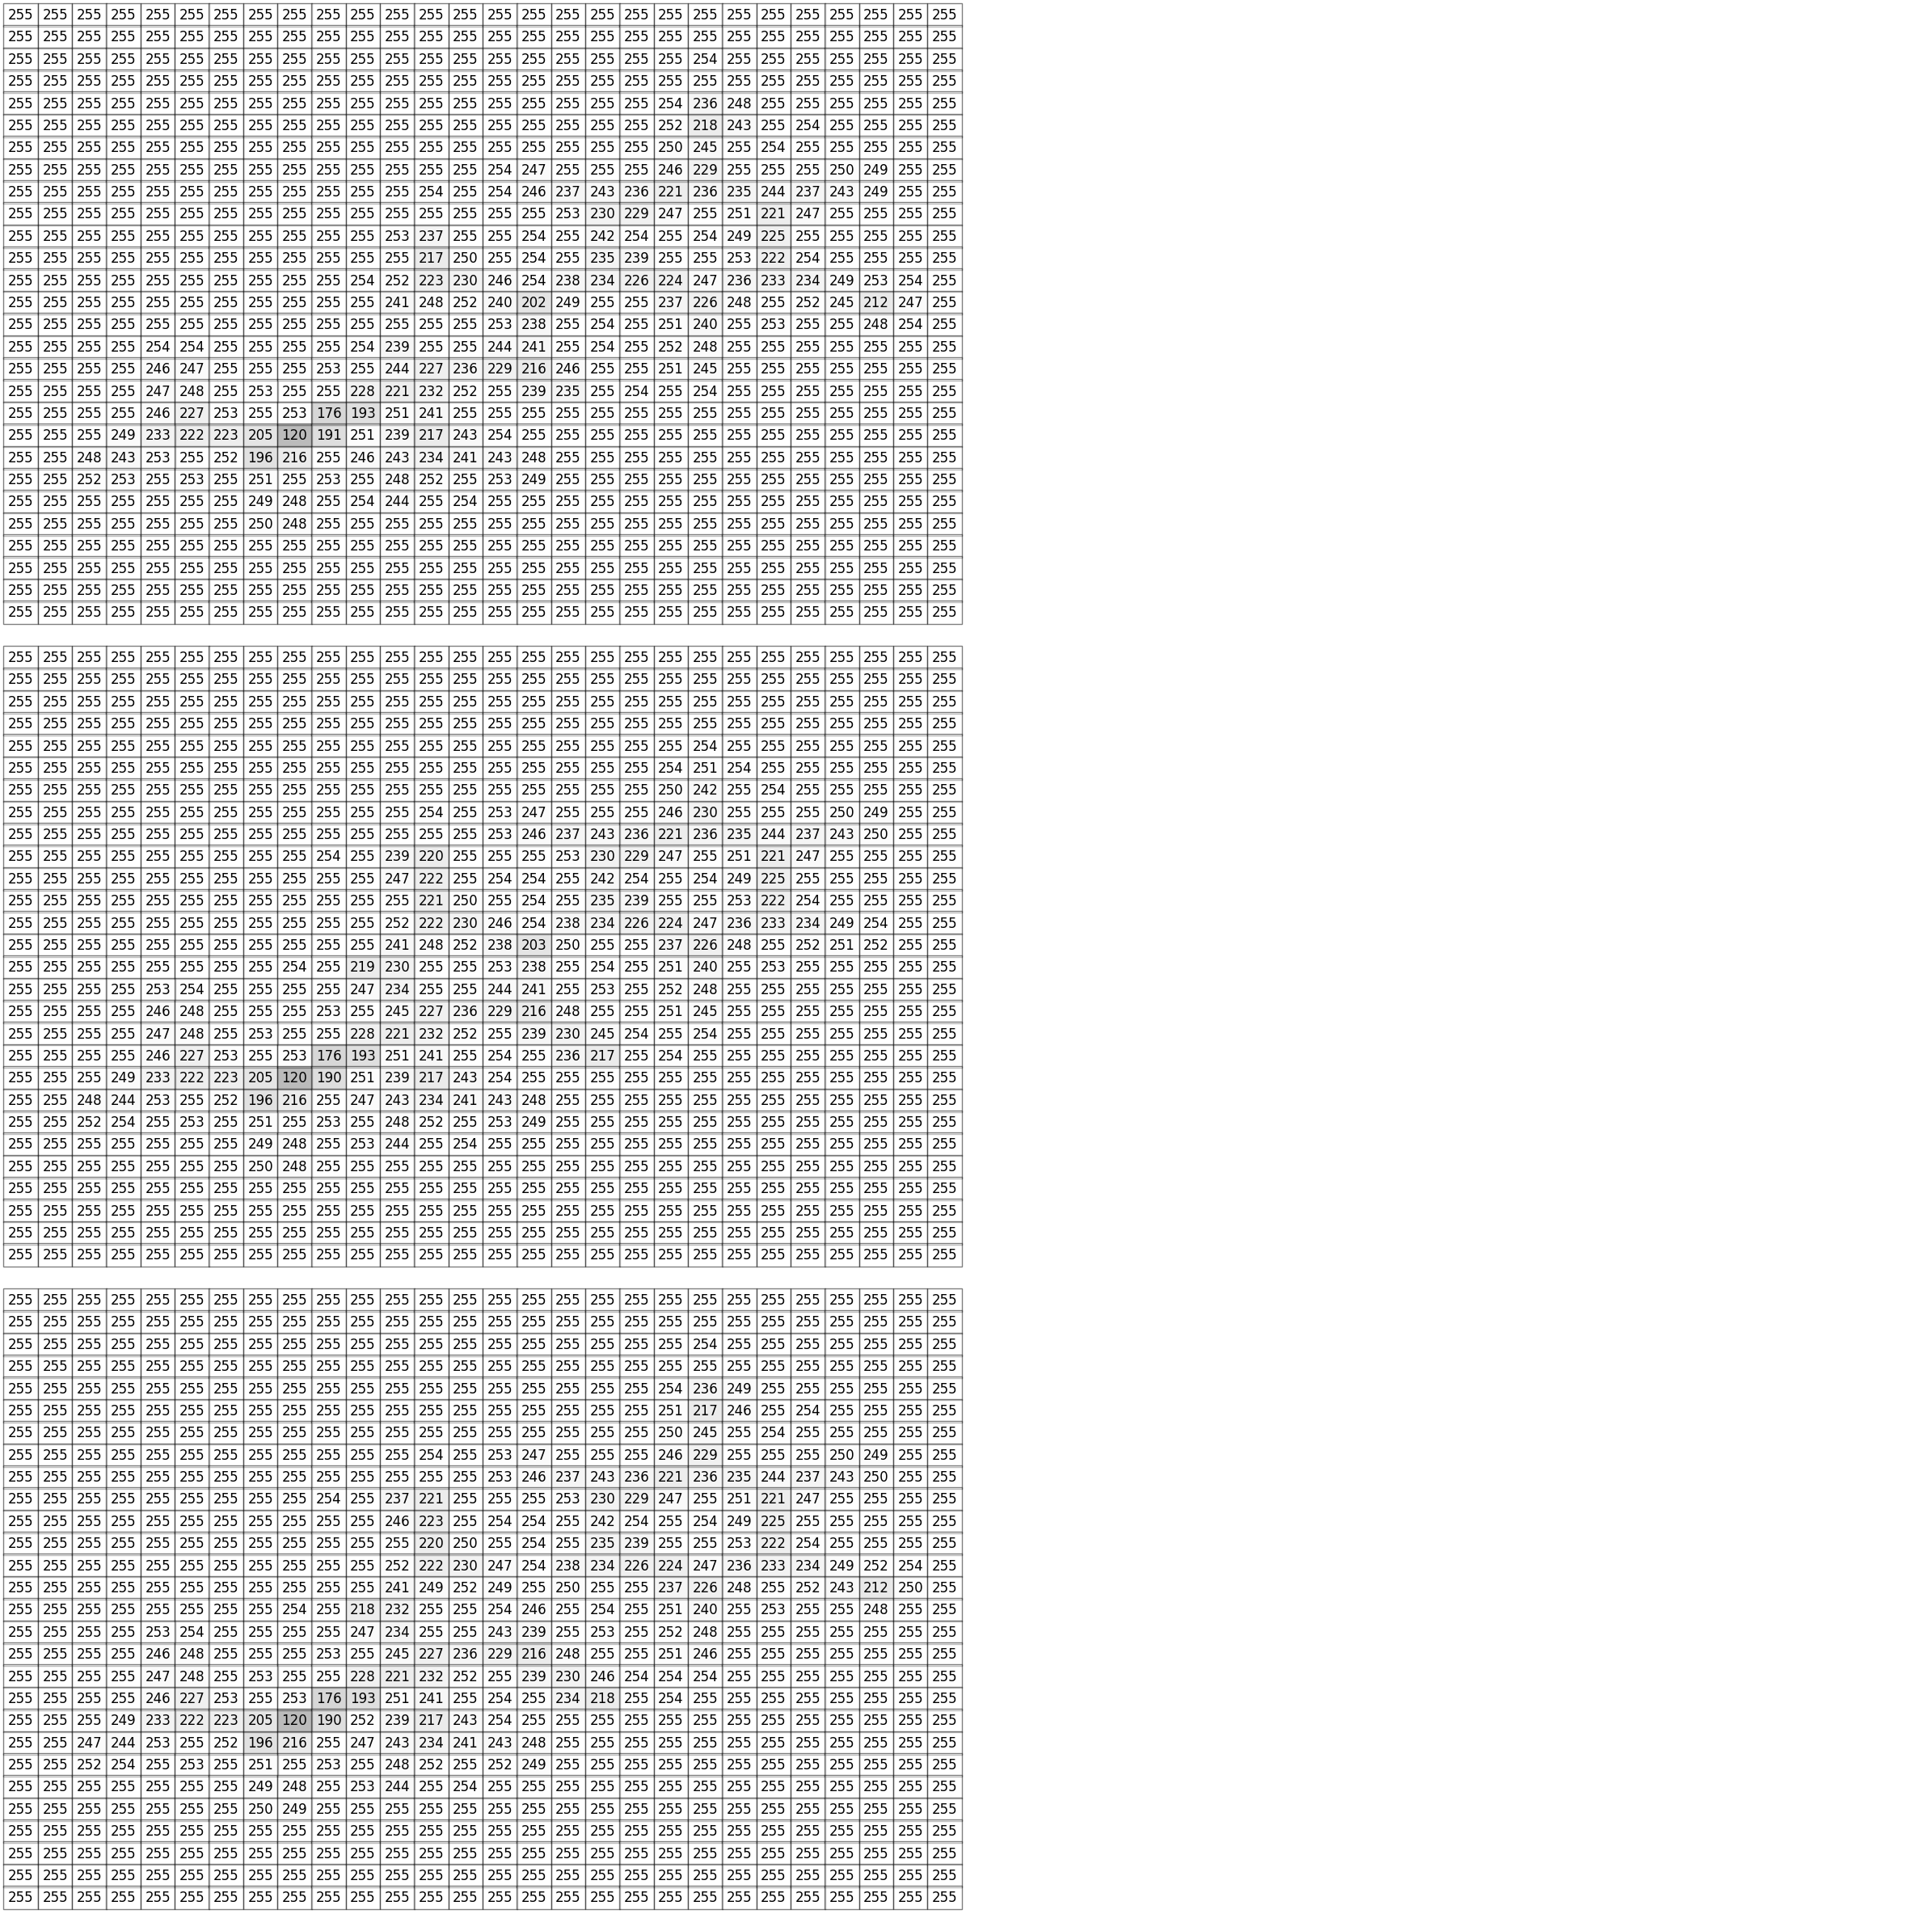

In [187]:
'''
Gráfico de dígitos
'''
grafico_digitos(dataset_imagenes['Imagen'][98], 28)


###Preprocesamiento

In [188]:
dataset_entrenar = preprocesar(dataset_imagenes, nuevo_ancho, nuevo_alto, opciones, asociaciones)


Tamaño: 
(32, 32)
Cambiado a gris


Se han truncado las últimas 5000 líneas del flujo de salida.
<ipython-input-155-2c298566a58b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_entrenar['primera_imagen'][i] = 1 - dataset_entrenar['primera_imagen'][i]
<ipython-input-155-2c298566a58b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_entrenar['segunda_imagen'][i] = 1 - dataset_entrenar['segunda_imagen'][i]
<ipython-input-155-2c298566a58b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

##Selección separación datos##

In [189]:
tamano_entrenamiento = 0.4
tamano_test = 0.5
semilla = 1

caracteristicas1_train, caracteristicas1_val, caracteristicas1_test, caracteristicas2_train, caracteristicas2_val, caracteristicas2_test, etiquetas_train, etiquetas_val, etiquetas_test = separar_datos(
    dataset_entrenar, tamano_entrenamiento, tamano_test, semilla)

datos = {
    'caracteristicas1_train': caracteristicas1_train,
    'caracteristicas1_val': caracteristicas1_val,
    'caracteristicas1_test': caracteristicas1_test,
    'caracteristicas2_train': caracteristicas2_train,
    'caracteristicas2_val': caracteristicas2_val,
    'caracteristicas2_test': caracteristicas2_test,
    'etiquetas_train': etiquetas_train,
    'etiquetas_val': etiquetas_val,
    'etiquetas_test': etiquetas_test
}
print(dataset_entrenar.shape)

(2834, 3)


##Selección modelo##

In [190]:
batch_size=1000

#prediccionesBasico = ejecutar_basico(epocas, batch_size, canales, datos, nuevo_ancho, nuevo_alto)
prediccionesLambda = ejecutar_lambda(epocas, batch_size, canales, datos, nuevo_ancho, nuevo_alto)
#prediccionesXception = ejecutar_xception(epocas, batch_size, canales, datos, nuevo_ancho, nuevo_alto)





Modelo lambda
Epoch 1/10
2/2 [==============================] - 6s 2s/step - loss: 0.2143 - val_loss: 0.1772 - lr: 0.0010
Epoch 2/10
2/2 [==============================] - 5s 3s/step - loss: 0.1672 - val_loss: 0.1196 - lr: 0.0010
Epoch 3/10
2/2 [==============================] - 5s 2s/step - loss: 0.1110 - val_loss: 0.0752 - lr: 0.0010
Epoch 4/10
2/2 [==============================] - 8s 4s/step - loss: 0.0834 - val_loss: 0.0970 - lr: 0.0010
Epoch 5/10
2/2 [==============================] - 7s 2s/step - loss: 0.1030 - val_loss: 0.0805 - lr: 0.0010
Epoch 6/10
2/2 [==============================] - 4s 2s/step - loss: 0.0848 - val_loss: 0.0764 - lr: 0.0010
Epoch 7/10
2/2 [==============================] - 4s 2s/step - loss: 0.0826 - val_loss: 0.0843 - lr: 0.0010
Epoch 8/10
2/2 [==============================] - 5s 3s/step - loss: 0.0882 - val_loss: 0.0838 - lr: 0.0010
Epoch 9/10
2/2 [==============================] - 4s 2s/step - loss: 0.0862 - val_loss: 0.0775 - lr: 0.0010
Epoch 10/10
18